# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [3]:
from sklearn import preprocessing
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sys
import tensorflow as tf
import csv
import glob

import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, to_categorical
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

np.set_printoptions(threshold=sys.maxsize)
%matplotlib inline

Using TensorFlow backend.


---
## Step 0: Load The Data

In [4]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "data/train.p"
validation_file= "data/valid.p"
testing_file = "data/test.p"
signnames_file = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(signnames_file, mode='r') as data:
    reader = csv.reader(data)
    next(reader)
    signnames_dict = dict(reader)  # pull in each row as a key-value pair
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_validation = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [6]:
def shuffle(batch, seed = 0):
    m = batch.shape[0]
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_batch = batch[permutation]
    return shuffled_batch, permutation

In [7]:
def shuffle_both(batch_1, batch_2, seed = 0):
    m = batch_1.shape[0]
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_batch_1 = batch_1[permutation]
    shuffled_batch_2 = batch_2[permutation]
    return shuffled_batch_1, shuffled_batch_2

In [8]:
def create_random_mini_batch(batch, n, seed = 0):
    np.random.seed(seed)
    shuffled_batch, permutation = shuffle(batch, seed = seed)
    m = shuffled_batch.shape[0]
    ind = np.random.randint(m-n)
    mini_batch = shuffled_batch[ind:ind+n]
    indices = permutation[ind:ind+n]
    return mini_batch, indices

In [9]:
def display_images(images, labels, signnames_dict):
    '''
    This function will display images in a grid set by the sizes of c and r.
    The number of rows and columns must be high enough to accomdate the
    number of images 
    :param images: list of images to be shown in the grid
    :param c: number of columns in the grid
    :param r: number of rows in the grid
    :return: displays images as per the plt.show() function
    '''
    # Visualize transformation
    w = 14
    h = 14
    axes = []
    fig = plt.figure(figsize=(w, h))
    columns = 3
    rows = len(images)//columns + 1
    
    for i in range(1, len(images) + 1):
        img = images[i-1]
        axes.append(fig.add_subplot(rows, columns, i))
        subplot_title = signnames_dict[str(labels[i-1])]
        axes[-1].set_title(subplot_title)
        plt.imshow(img,  cmap = plt.cm.gray)
    plt.show()

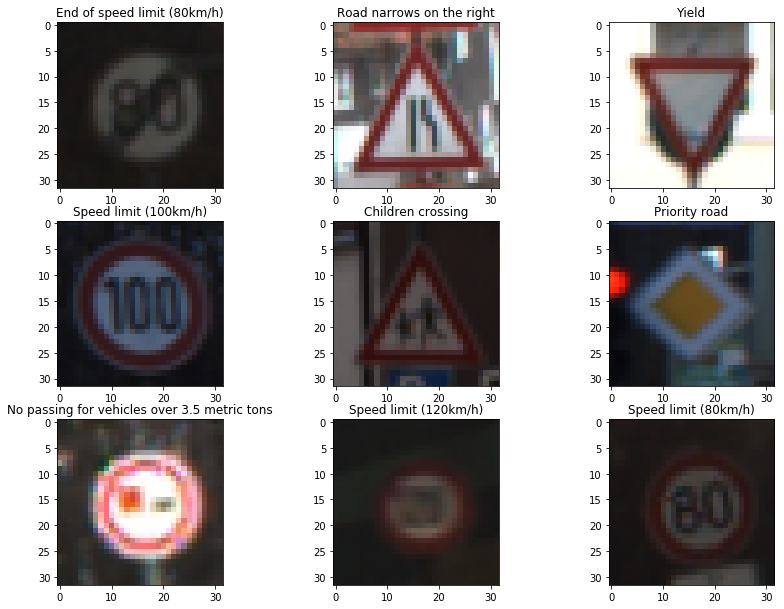

In [10]:
# Display
seed = np.random.randint(1000)

display_number = 9
mini_batch, indices = create_random_mini_batch(X_train, n = display_number, seed = seed)
labels = list(y_train[indices])
display_images(mini_batch, labels, signnames_dict)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [11]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

seed = np.random.randint(100000)
X_train, y_train = shuffle_both(X_train, y_train, seed = seed)

X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)
X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)

X_train_gray = X_train_gray/255 
X_valid_gray = X_valid_gray/255
X_test_gray = X_test_gray/255

y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of valid examples = " + str(X_valid.shape[0]))
print ("X_train shape: " + str(X_train_gray.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_valid shape: " + str(X_valid_gray.shape))
print ("Y_valid shape: " + str(y_valid.shape))
print ("X_test shape: " + str(X_test_gray.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 34799
number of valid examples = 4410
X_train shape: (34799, 32, 32, 1)
Y_train shape: (34799, 43)
X_valid shape: (4410, 32, 32, 1)
Y_valid shape: (4410, 43)
X_test shape: (12630, 32, 32, 1)
Y_test shape: (12630, 43)


### Model Architecture

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def lenet(input_shape = (32, 32, 3), classes = 43, seed = 0):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Zero Padding
    X_input = Input(shape=input_shape)
    
    X = X_input
    X = Conv2D(6, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2))(X)
    
    X = Conv2D(16, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=(2,2))(X)

    X = Flatten()(X)
    X = Dense(120, activation='relu', name='fc1')(X)
    X = Dense(84, activation='relu', name='fc2')(X)
    X = Dense(classes, activation='softmax', name='fc3')(X)

    # create model
    model = Model(inputs=X_input, outputs=X, name='LeNet-5')
    
    return model

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
seed = np.random.randint(1000)
model = lenet(input_shape = (32, 32, 1), classes = 43, seed = seed)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.fit(X_train_gray, y_train, epochs = 30, batch_size = 128)

Epoch 1/30
34799/34799 [==============================] - 4s 124us/step - loss: 1.2375 - acc: 0.6838
Epoch 2/30
34799/34799 [==============================] - 4s 115us/step - loss: 0.2348 - acc: 0.9413
Epoch 3/30
34799/34799 [==============================] - 4s 115us/step - loss: 0.1302 - acc: 0.9691
Epoch 4/30
34799/34799 [==============================] - 4s 114us/step - loss: 0.0931 - acc: 0.9774
Epoch 5/30
34799/34799 [==============================] - 4s 114us/step - loss: 0.0649 - acc: 0.9849
Epoch 6/30
34799/34799 [==============================] - 4s 113us/step - loss: 0.0452 - acc: 0.9899
Epoch 7/30
34799/34799 [==============================] - 4s 113us/step - loss: 0.0448 - acc: 0.9894
Epoch 8/30
34799/34799 [==============================] - 4s 112us/step - loss: 0.0357 - acc: 0.9906
Epoch 9/30
34799/34799 [==============================] - 4s 112us/step - loss: 0.0265 - acc: 0.9932
Epoch 10/30
34799/34799 [==============================] - 4s 112us/step - loss: 0.0281 - a

In [15]:
model =  keras.models.load_model('model')

In [16]:
preds = model.evaluate(X_valid_gray, y_valid)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]*100))

4410/4410 [==============================] - 4s 877us/step
Loss = 0.353493301266
Test Accuracy = 94.9886621153


In [17]:
preds = model.evaluate(X_test_gray, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]*100))

12630/12630 [==============================] - 11s 852us/step
Loss = 0.526835071145
Test Accuracy = 93.2462391094


In [46]:
model.save("model")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [18]:
model =  keras.models.load_model('model')

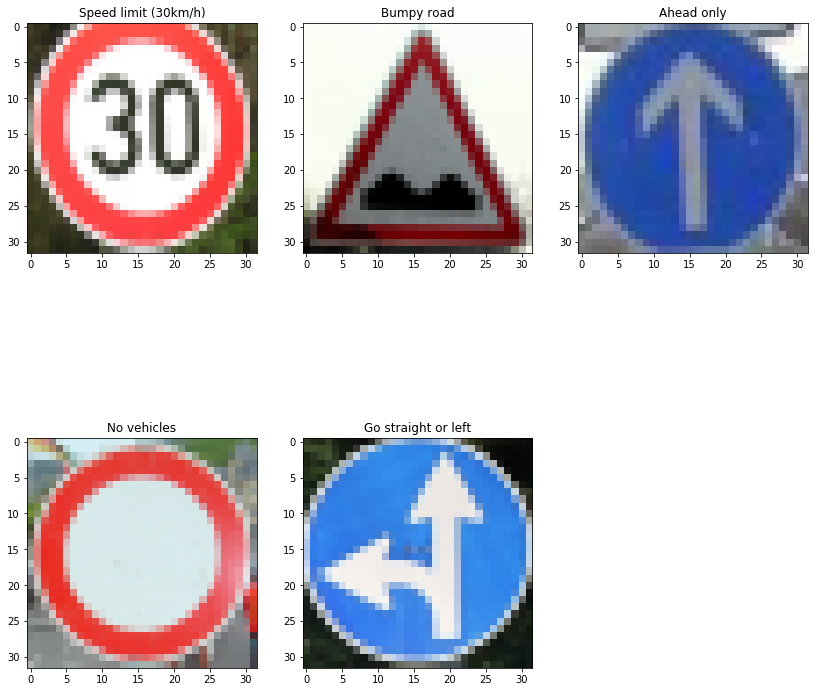

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
my_images_reader = sorted(glob.glob('data/mysigns/*.png'))
my_images = []
for i in my_images_reader:
    img = plt.imread(i)
    my_images.append(img)
    
my_images = np.array(my_images)
my_labels = [1, 22, 35, 15, 37]
display_images(my_images, my_labels, signnames_dict)

### Predict the Sign Type for Each Image

In [20]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
my_images_gray = np.sum(my_images/3, axis=3, keepdims=True)
my_images_gray = my_images_gray/255
predicted_labels = []
for i in my_images_gray:
    i = np.expand_dims(i, axis=0)
    prediction = model.predict(i)
    predicted_sign = np.argmax(prediction)
    predicted_labels.append(predicted_sign)

for l in range(len(predicted_labels)):
    pred = signnames_dict[str(predicted_labels[l])]
    correct = signnames_dict[str(my_labels[l])]
    
    print("prediction: " + pred + " || correct label: " + correct)

prediction: Speed limit (30km/h) || correct label: Speed limit (30km/h)
prediction: General caution || correct label: Bumpy road
prediction: Ahead only || correct label: Ahead only
prediction: Priority road || correct label: No vehicles
prediction: Go straight or left || correct label: Go straight or left


### Analyze Performance

In [21]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
performance = len(set(predicted_labels) & set(my_labels))/len(my_labels) * 100
print("performance on five user images: " + str(performance) + '%')


performance on five user images: 60.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [22]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
print("correct labels:   " + str(my_labels))
print("predicted labels: " + str(predicted_labels))
for i in my_images_gray:
    i = np.expand_dims(i, axis=0)
    prediction = model.predict(i)
    d = tf.nn.top_k(prediction, k=5, sorted=True, name=None)
    with tf.Session() as sess:
        top_k = sess.run(tf.nn.top_k(tf.constant(prediction), k = 5))
        print("softmax propabilities: " + str(top_k.values))
        print("softmax indices: " + str(top_k.indices))
        print("----------------------------")
        
    #print(d)
    #print(prediction)

correct labels:   [1, 22, 35, 15, 37]
predicted labels: [1, 18, 35, 12, 37]
softmax propabilities: [[  9.68968451e-01   2.42639668e-02   5.72419912e-03   1.00884261e-03
    2.26735901e-05]]
softmax indices: [[ 1 40  0 11 21]]
----------------------------
softmax propabilities: [[ 0.96857262  0.02017878  0.00582511  0.00173524  0.00166605]]
softmax indices: [[18 26 22 20 29]]
----------------------------
softmax propabilities: [[ 0.87520444  0.06864772  0.01504244  0.01327465  0.00573052]]
softmax indices: [[35  9 40 15 12]]
----------------------------
softmax propabilities: [[ 0.78527117  0.12316429  0.0403613   0.03349018  0.00679407]]
softmax indices: [[12 40 32 15 35]]
----------------------------
softmax propabilities: [[  9.99319673e-01   3.77239077e-04   1.73904045e-04   1.10524539e-04
    9.85963834e-06]]
softmax indices: [[37 40 39 26 17]]
----------------------------


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 6)         156       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 28, 28, 6)         24        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 16)        2416      
_________________________________________________________________
bn_conv2 (BatchNormalization (None, 10, 10, 16)        64        
__________

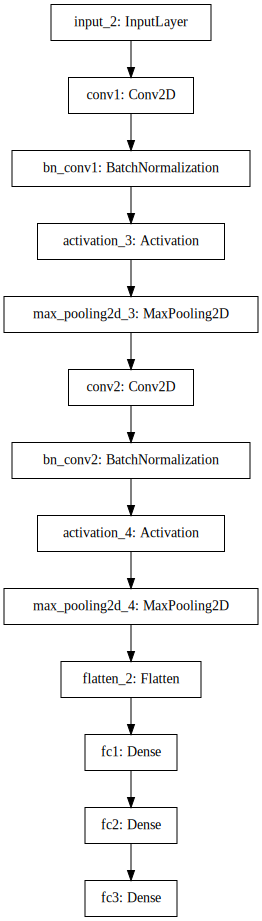

In [24]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))